# 使用RNN预测股票下一日的收盘价

这基本是一个不可能完成的任务，不过作为RNN的练习，还是一个不错的题目：有数据，有场景，有吸引力。本案例主要参考：https://github.com/DarkKnight1991/Stock-Price-Prediction ，这是一个`many-to-one`的RNN案例，即通过前60日股价数据（open,close,high,low,volume）预测下一日的收盘价，其中feature size=5。

先上运行结果图：![prediction result](images/stock-pred-result.png)

But，这里仅仅是一个练习，不作为投资参考，请参见：https://www.blueskycapitalmanagement.com/machine-learning-in-finance-why-you-should-not-use-lstms-to-predict-the-stock-market/

# 导入必要的包
这里使用了sklearn包的MinMaxScaler进行数据的预处理。

In [1]:
# import tensorflow as tf
# import tensorflow.keras as keras
import numpy as np
import os
import sys
import time
import pandas as pd
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Shanghai'  # to set timezone; needed when running on cloud
time.tzset()

# 集中设置参数

In [3]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300, # 由于启用了earlyStopping机制，通常会提前终止
    "lr": 0.00010000, # 学习率
    "time_steps": 60 # RNN的(最大？)滑动窗口大小，这是使用60日的数据预测下一日的某个特征
}

iter_changes = "dropout_layers_0.4_0.4"
DATA_FILE="ge.us.txt"
PATH_TO_DRIVE_ML_DATA="./"
INPUT_PATH = PATH_TO_DRIVE_ML_DATA+"inputs"
OUTPUT_PATH = PATH_TO_DRIVE_ML_DATA+"outputs/"+time.strftime("%Y-%m-%d")+"/"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]
stime = time.time()

In [4]:
# check if directory already exists
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    print("Directory created", OUTPUT_PATH)
else:
    os.rename(OUTPUT_PATH, OUTPUT_PATH+str(stime))
    os.makedirs(OUTPUT_PATH)
    print("Directory recreated", OUTPUT_PATH)

Directory recreated ./outputs/2019-05-13/dropout_layers_0.4_0.4


构造训练数据的方法参见下图，注意颜色相同的矩形块框出了输入数据和预测数据，图中的窗口尺寸（time_steps）是3，即使用前3天的数据预测下一日的收盘价。显然，如果样本数为`N`，则可划分的输入样本数为`N-time_steps`。

![build serial time data](images/stock-pred-data.png)

In [5]:
def print_time(text, stime):
    seconds = (time.time()-stime)
    print(text, seconds//60,"minutes : ",np.round(seconds%60),"seconds")


def trim_dataset(mat,batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat


def build_timeseries(mat, y_col_index):
    """
    Converts ndarray into timeseries format and supervised data format. Takes first TIME_STEPS
    number of rows as input and sets the TIME_STEPS+1th data as corresponding output and so on.
    :param mat: ndarray which holds the dataset
    :param y_col_index: index of column which acts as output
    :return: returns two ndarrays-- input and output in format suitable to feed
    to LSTM.
    """
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    print("dim_0",dim_0)
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
#         if i < 10:
#           print(i,"-->", x[i,-1,:], y[i])
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


stime = time.time()
print(os.listdir(INPUT_PATH))

['ge.us.txt']


# 构造训练数据

Again，RNN的输入数据要求的shape是(batch_size, time_steps, feature_size)

In [6]:
df_ge = pd.read_csv(os.path.join(INPUT_PATH, DATA_FILE))
print(df_ge.shape)
print(df_ge.tail())
tqdm_notebook.pandas('Processing...')
print(df_ge.dtypes)
train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train--Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

print("Deleting unused dataframes of total size(KB)",
      (sys.getsizeof(df_ge)+sys.getsizeof(df_train)+sys.getsizeof(df_test))//1024)

del df_ge
del df_test
del df_train
del x

print("Are any NaNs present in train/test matrices?",np.isnan(x_train).any(), np.isnan(x_train).any())
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed x_t size",x_t.shape)
print("Batch trimmed y_t size",y_t.shape)

(14058, 7)
             Date   Open    High    Low  Close     Volume  OpenInt
14053  2017-11-06  20.52  20.530  20.08  20.13   60641787        0
14054  2017-11-07  20.17  20.250  20.12  20.21   41622851        0
14055  2017-11-08  20.21  20.320  20.07  20.12   39672190        0
14056  2017-11-09  20.04  20.071  19.85  19.99   50831779        0
14057  2017-11-10  19.98  20.680  19.90  20.49  100698474        0
Date        object
Open       float64
High       float64
Low        float64
Close      float64
Volume       int64
OpenInt      int64
dtype: object
Train--Test size 11246 2812
Deleting unused dataframes of total size(KB) 3267
Are any NaNs present in train/test matrices? False False
dim_0 11186



length of time-series i/o (11186, 60, 5) (11186,)
Batch trimmed x_t size (11180, 60, 5)
Batch trimmed y_t size (11180,)


# 创建训练模型
batch_input_shape中的第二个参数分别为None和TIME_STEPS的区别何在？
* None:
* TIME_STEPS(60):

In [7]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, None, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    # 在这里SGD很难得到理想的结果，RMSprop一般可以比较好的收敛
    optimizer = optimizers.RMSprop(lr=params["lr"])
    #optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model


model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model:",model)
    model.summary()
except FileNotFoundError:
    print("Model not found")
    model = create_model()

model.summary()

Model not found
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (20, None, 100)           42400     
_________________________________________________________________
dropout_1 (Dropout)          (20, None, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (20, 60)                  38640     
_________________________________________________________________
dropout_2 (Dropout)          (20, 60)                  0         
_________________________________________________________________
dense_1 (Dense)              (20, 20)                  1220      
_________________________________________________________________
dense_2 (Dense)              (20, 1)                   21        
Total params: 82,281
Trainable params: 82,281
Non-trainable params: 0
________________________________________________________

# 准备测试数据和验证数据

In [8]:
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)

dim_0 2752



length of time-series i/o (2752, 60, 5) (2752,)
Test size (1370, 60, 5) (1370,) (1370, 60, 5) (1370,)


BATCH_SIZE对执行速度影响很大，以下是一些测试结果：

|BATCH_SIZE|耗时（s/epoch)|
|------|------|
|10|50|
|20|50|
|512|5|

但是，过大的batch_size会影响预测结果，参见：https://datascience.stackexchange.com/questions/16807/why-mini-batch-size-is-better-than-one-single-batch-with-all-training-data

In [9]:
is_update_model = True
if model is None or is_update_model:
#     from keras import backend as K
#     print("Building model...")
#     print("checking if GPU available", K.tensorflow_backend._get_available_gpus())

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=1, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, csv_logger, mcp])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

Building model...
checking if GPU available []
Train on 11180 samples, validate on 1360 samples
Epoch 1/300
11180/11180 [==============================] - 158s 14ms/step - loss: 0.0215 - val_loss: 0.0270

Epoch 00001: val_loss improved from inf to 0.02698, saving model to ./outputs/2019-05-13/dropout_layers_0.4_0.4/best_model.h5
Epoch 2/300
11180/11180 [==============================] - 148s 13ms/step - loss: 0.0070 - val_loss: 0.0046

Epoch 00002: val_loss improved from 0.02698 to 0.00459, saving model to ./outputs/2019-05-13/dropout_layers_0.4_0.4/best_model.h5
Epoch 3/300
11180/11180 [==============================] - 149s 13ms/step - loss: 0.0026 - val_loss: 0.0035

Epoch 00003: val_loss improved from 0.00459 to 0.00351, saving model to ./outputs/2019-05-13/dropout_layers_0.4_0.4/best_model.h5
Epoch 4/300
11180/11180 [==============================] - 143s 13ms/step - loss: 0.0021 - val_loss: 0.0030

Epoch 00004: val_loss improved from 0.00351 to 0.00296, saving model to ./outputs/

11180/11180 [==============================] - 43s 4ms/step - loss: 6.2232e-04 - val_loss: 0.0035

Epoch 00047: val_loss did not improve from 0.00244
Epoch 00047: early stopping
saving model...


In [10]:
#model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE)

# 预测
根据x_test_t进行预测

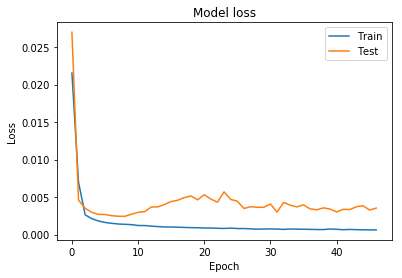

<Figure size 432x288 with 0 Axes>

In [11]:
# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

In [12]:
def plot_pred(pred, real, title):
    """绘制预测和实际的比较图"""
    plt.figure()
    plt.plot(pred)
    plt.plot(real)
    plt.title(title)
    plt.ylabel('Price')
    plt.xlabel('Days')
    plt.legend(['Prediction', 'Real'])
    plt.show()

def stock_pred(x, y, debug=True, title='Prediction vs Real Stock Price', batch_size=BATCH_SIZE):
    '''
    收盘价预测
    但是，这里没有越雷池一步，即没有往前走哪怕一小步。
    x: 输入样本列表
    y：labels，真实股价列表
    batch_size: 进行预测时的batch_size。当给出的样本数量小时，需要减少batch_size以适配之
    '''
    print('batch size:',batch_size)
    y_pred = model.predict(trim_dataset(x, batch_size), batch_size=batch_size)
    if debug==True:
        print(y_pred)
    y_pred = y_pred.flatten()
    y_test_t = trim_dataset(y, batch_size)
    error = mean_squared_error(y_test_t, y_pred)
    if debug==True:
        print("Error is", error, y_pred.shape, y_test_t.shape)
        print(y_pred[0:15])
        print(y_test_t[0:15])
    y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
    y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
    if debug==True:
        print(y_pred_org[0:15])
        print(y_test_t_org[0:15])

    # Visualize the prediction
    plot_pred(y_pred_org, y_test_t_org, title)
    plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(batch_size)+"_"+str(len(x))+'.png'))

batch size: 20
[[0.38616067]
 [0.38537163]
 [0.38446143]
 ...
 [0.5046977 ]
 [0.50109833]
 [0.49753407]]
Error is 0.0014014407971811354 (1360,) (1360,)
[0.38616067 0.38537163 0.38446143 0.3840186  0.38367152 0.38312197
 0.38310686 0.3834642  0.38385674 0.38410372 0.3841346  0.38377628
 0.38285103 0.38217917 0.3807698 ]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[18.839104 18.801546 18.758224 18.737146 18.720627 18.69447  18.69375
 18.710758 18.729443 18.741198 18.742668 18.725613 18.681574 18.649595
 18.582514]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]


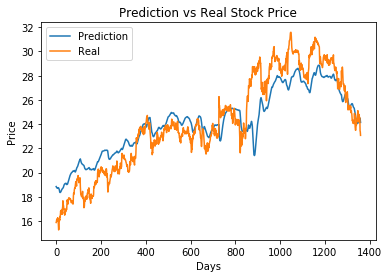

program completed  49.0 minutes :  8.0 seconds


<Figure size 432x288 with 0 Axes>

In [13]:
stock_pred(x_test_t, y_test_t)
print_time("program completed ", stime)

## 最近N天的走势放大图
将测试集的最近N天的走势放大了来看看，似乎预测曲线更加平顺。

In [14]:
# for days in (200,100,60,20,10):
#     y_pred = y_pred_org[-days:]
#     y_test_t = y_test_t_org[-days:]
#     plot_pred(y_pred,y_test_t,'Prediction vs Real Stock Price(latest ' + str(days) + ' days)')

## 最近N天的走势预测
在执行这个block之前，最好将测试数据重新生成一遍，以免相互影响造成测试数据的改变。

In [15]:
x_temp, y_temp = build_timeseries(x_test, 3)
_, x_test_t = np.split(x_temp,2)
_, y_test_t = np.split(y_temp,2)

# for days in (200,100,60,20):
#     x = x_test_t[-days:]
#     y = y_test_t[-days:]
#     stock_pred(x, y, debug=False, title='Prediction vs Real Stock Price(latest ' + str(days) + ' days)')
    
x = x_test_t[-1:]
y = y_test_t[-1:]
stock_pred(x, y, debug=True, title='Prediction vs Real Stock Price(latest ' + str(1) + ' days)',batch_size=1)

dim_0 2752



length of time-series i/o (2752, 60, 5) (2752,)
batch size: 1


ValueError: could not broadcast input array from shape (20,1) into shape (1,1)

# 后记

* 如何逐步的观察预测的结果？比如给出前60天的数据作为x_test，然后只预测出下一天的收盘价？
* 如果预测是开盘价呢？
* 改造为猜第二天的涨跌
* 改造成many-to-many的案例，即根据前N天的数据预测后M天的收盘价
* 如何显示真实的日期？